In [ ]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Iterable


import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [13]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(DQN, self).__init__()
        
        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        self.linear1 = nn.Linear(32*4*4, 128)
        self.linear2 = nn.Linear(128, num_actions)
        
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear1(x))
        q_value = self.linear2(x)
        return q_value

In [14]:
class Duelling_DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(Duelling_DQN, self).__init__()

        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)

        self.linear = nn.Linear(32*6*6, 512)

        self.value = nn.Linear(512, 1)
        self.advantage = nn.Linear(512, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear(x))

        value = self.value(x)
        advantage = self.advantage(x)

        q_value = value + advantage - torch.sum(advantage)/self.action_num

        return q_value

In [15]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [16]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    # TODO: your code
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

In [17]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)   
        self.position = (self.position + 1) % self.max_size         

    def sample(self, batch_size: int) -> torch.Tensor:
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

In [18]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    loss.backward()
    optimizer.step()


In [19]:
def update_ddqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

    q_val = q(obs).gather(1, act.type(torch.int64).unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    mseloss.backward()
    optimizer.step()

In [20]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        self.buffer = ReplayBuffer(maxlen)
        self.q = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [21]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        self.buffer = ReplayBuffer(maxlen)
        self.q = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [22]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class Duelling_DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        self.buffer = ReplayBuffer(maxlen)
        self.q = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [25]:
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 70_000
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99

# Train DQN
agent_dqn = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_dqn = agent_dqn.train(NUM_EPISODES)


# Train DDQN
agent_ddqn = DDQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_ddqn = agent_ddqn.train(NUM_EPISODES)


# Train Duelling DDQN
agent_duelling_ddqn = Duelling_DDQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_duelling_ddqn = agent_duelling_ddqn.train(NUM_EPISODES)


Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

Episode 100 of 1000  Time Step: 7044  Epsilon: 0.455
Episode 200 of 1000  Time Step: 17229  Epsilon: 0.389
Episode 300 of 1000  Time Step: 27892  Epsilon: 0.321
Episode 400 of 1000  Time Step: 41855  Epsilon: 0.231
Episode 500 of 1000  Time Step: 58121  Epsilon: 0.126
Episode 600 of 1000  Time Step: 77878  Epsilon: 0.050
Episode 700 of 1000  Time Step: 95914  Epsilon: 0.050
Episode 800 of 1000  Time Step: 114728  Epsilon: 0.050
Episode 900 of 1000  Time Step: 134077  Epsilon: 0.050
Episode 1000 of 1000  Time Step: 152460  Epsilon: 0.050
Episode 100 of 1000  Time Step: 5179  Epsilon: 0.467
Episode 200 of 1000  Time Step: 15318  Epsilon: 0.402
Episode 300 of 1000  Time Step: 27099  Epsilon: 0.326
Episode 400 of 1000  Time Step: 39496  Epsilon: 0.246
Episode 500 of 1000  Time Step: 53848  Epsilon: 0.154
Episode 600 of 1000  Time Step: 70240  Epsilon: 0.050
Episode 700 of 

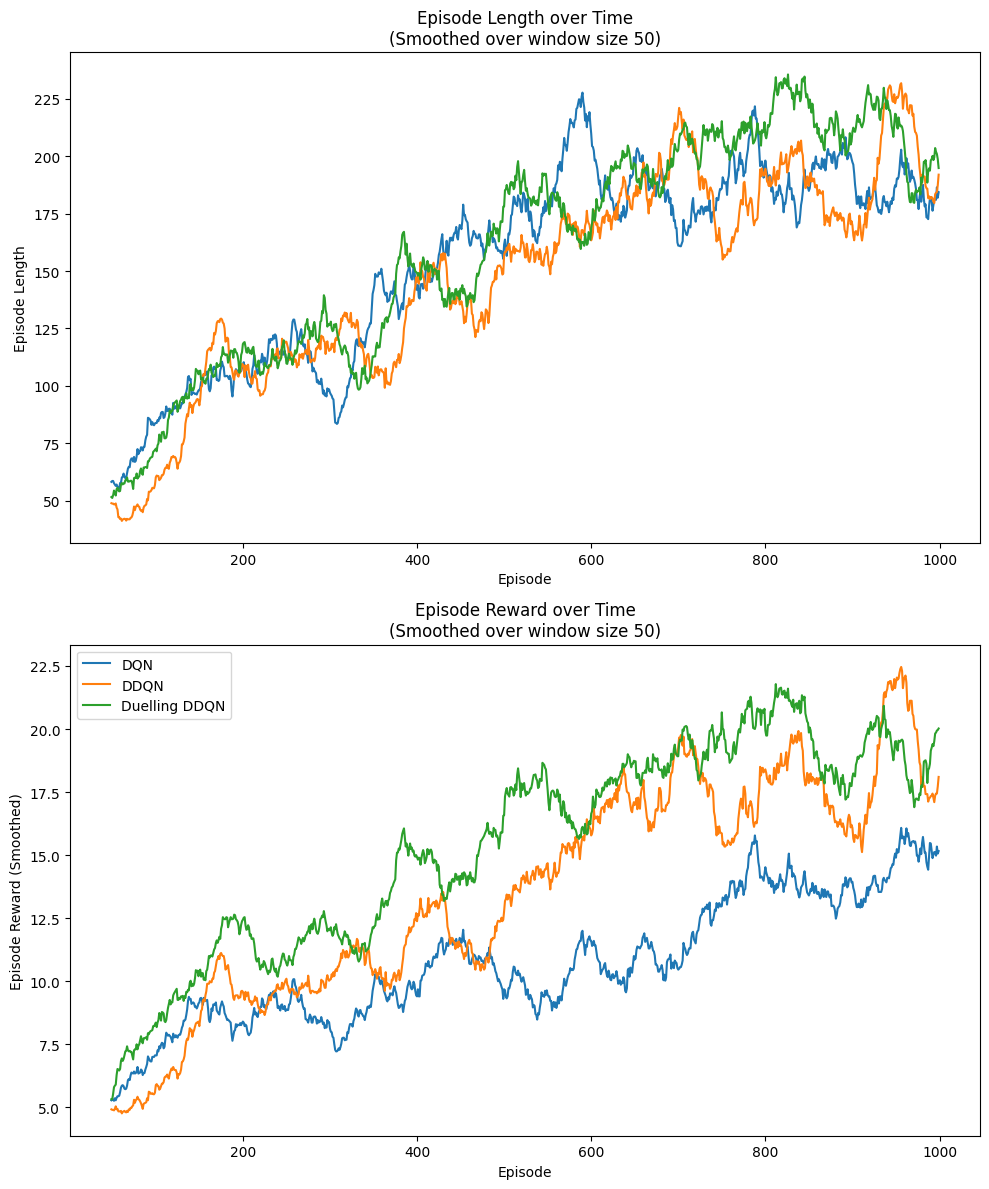

In [26]:
smoothing_window=50
fig, axes = plt.subplots(2, 1, figsize=(10, 12), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
lengths_smoothed_dqn = pd.Series(stats_dqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed_ddqn = pd.Series(stats_ddqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed_duelling_ddqn = pd.Series(stats_duelling_ddqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(lengths_smoothed_dqn)
ax.plot(lengths_smoothed_ddqn)
ax.plot(lengths_smoothed_duelling_ddqn)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title(f"Episode Length over Time\n(Smoothed over window size {smoothing_window})")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed_dqn = pd.Series(stats_dqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed_ddqn = pd.Series(stats_ddqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed_duelling_ddqn = pd.Series(stats_duelling_ddqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed_dqn, label="DQN")
ax.plot(rewards_smoothed_ddqn, label="DDQN")
ax.plot(rewards_smoothed_duelling_ddqn, label="Duelling DDQN")
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.legend() 
plt.show()